# Actor Critic method on CartPole (PyTorch)

In this notebook Actor Critic (A2C) method is applied for CartPole environment from OpenAI gym, with PyTorch. Actor Critic method is :

*   Combination of policy-based and value-vased method


Some ideas of the code are taken from the book: Deep Reinforcement Learning Hands-On, 2nd edition, from Packt publishing, by Maxim Lapan. 

Also Ptan library is used to simplify the code.


## 1. Import modules

In [1]:
pip install ptan==0.7

In [2]:
import gym
import ptan
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import time

In [3]:
GAMMA = 0.99
REWARD_STEPS = 4
HIDDEN_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 0.001
ENTROPY_BETA = 0.01 # this improves exploration
MIN_TS_DIFF = 1.0

## 2. Build the model

In [4]:
class CartPoleA2C(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(CartPoleA2C, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(hidden_size, n_actions)
        )
        self.value = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        common_out = self.common(x)
        return self.policy(common_out), self.value(common_out)

## 3. Converting batch of transitions to numpy arrays for training

In [5]:
# Batch of transitions is unpacked to numpy arrays
# Each item in the batch is namedtuple with fields state,action,reward,last_state
# The states where last_state is None (episode ended), are masked in loss calculation

def unpack_batch(batch, net):
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)

    states_v = torch.FloatTensor(states)
    actions_t = torch.LongTensor(actions)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    # Next is done  only for last states not being terminal values (not_done)
    # Ie Q(s',a)*gamma**reward_steps value is added for qvals
    if not_done_idx:
        last_states_v = torch.tensor(np.array(last_states, dtype=np.float32 ))
        last_vals_v = net(last_states_v)[1] # [1] -> value part, Q(s',a)
        last_vals_np = last_vals_v.data.numpy()[:, 0] 
        last_vals_np *= GAMMA ** REWARD_STEPS # considering gamma only for REWARD_STEPS period
        rewards_np[not_done_idx] += last_vals_np

    ref_qvals_v = torch.FloatTensor(rewards_np)
    return states_v, actions_t, ref_qvals_v


In [6]:
class TrainingTiming():
  def __init__(self, min_ts_diff=1.0):
    self.min_ts_diff = min_ts_diff
    self.ts = time.time()
    self.ts_frame = 0
  
  def timecheck(self, frame):
    ts_diff = time.time() - self.ts
    if ts_diff > self.min_ts_diff:
      speed = (frame - self.ts_frame) / ts_diff
      self.ts_frame = frame
      self.ts = time.time()
      return speed
    return None

## 5. Play the game, create batches of transitions and train the network

In [7]:
env = gym.make("CartPole-v0")

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

net = CartPoleA2C(obs_size, HIDDEN_SIZE, n_actions)
print(net)

agent = ptan.agent.PolicyAgent(lambda x: net(x)[0], preprocessor=ptan.agent.float32_preprocessor,apply_softmax=True)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, eps=1e-3)

batch = []
losses=[]
total_rewards=[]
mean_reward = 0
timer = TrainingTiming()

for step_idx, exp in enumerate(exp_source):
    batch.append(exp)

    # handle new total rewards from terminated episodes
    new_total_reward = exp_source.pop_total_rewards()

    if new_total_reward:
        total_rewards.append(new_total_reward)
        mean_reward = np.mean(total_rewards[-100:])
        speed = timer.timecheck(step_idx)
        if speed: 
            print(f"{step_idx}: loss={loss_v.item():.4f}, \
              mean reward={mean_reward:.3f}, speed={speed:.2f} f/s")
            sys.stdout.flush()

        if mean_reward > 195:  # the task solved
            print(f"Solved at episode: {step_idx} with mean reward: {mean_reward}")
            break

    if len(batch) < BATCH_SIZE:
        continue

    states_v, actions_t, vals_ref_v = unpack_batch(batch, net)
    batch.clear()

    optimizer.zero_grad()
    logits_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

    log_prob_v = F.log_softmax(logits_v, dim=1)
    adv_v = vals_ref_v - value_v.detach()
    log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
    loss_policy_v = -log_prob_actions_v.mean()

    prob_v = F.softmax(logits_v, dim=1)
    entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

    # calculate policy gradients only
    loss_policy_v.backward(retain_graph=True)
    grads = np.concatenate([p.grad.data.numpy().flatten()
                            for p in net.parameters()
                            if p.grad is not None])

    # apply entropy and value gradients
    loss_v = entropy_loss_v + loss_value_v
    loss_v.backward()
    #nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    optimizer.step()
    # get full loss
    loss_v += loss_policy_v
    losses.append(loss_v.item())



CartPoleA2C(
  (common): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (policy): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)
2306: loss=14.5474,               mean reward=30.342, speed=2295.85 f/s
4802: loss=26.0186,               mean reward=37.440, speed=2408.66 f/s
7295: loss=9.7731,               mean reward=48.820, speed=2417.16 f/s
9664: loss=207.9294,               mean reward=55.490, speed=2350.37 f/s
12103: loss=9.0124,               mean reward=68.440, speed=2387.44 f/s
14529: loss=313.9891,               mean reward=76.300, speed=2298.12 f/s
16951: loss=7.5650,               mean reward=74.260, speed=2357.34 f/s
19326: loss=15.4801,               mean reward=81.280, speed=2354.21 f/s
21760: loss=498.0949,               mean reward=95.160, speed=2394.96 f/s
24202: loss=4.4322,               mean reward=96.730,

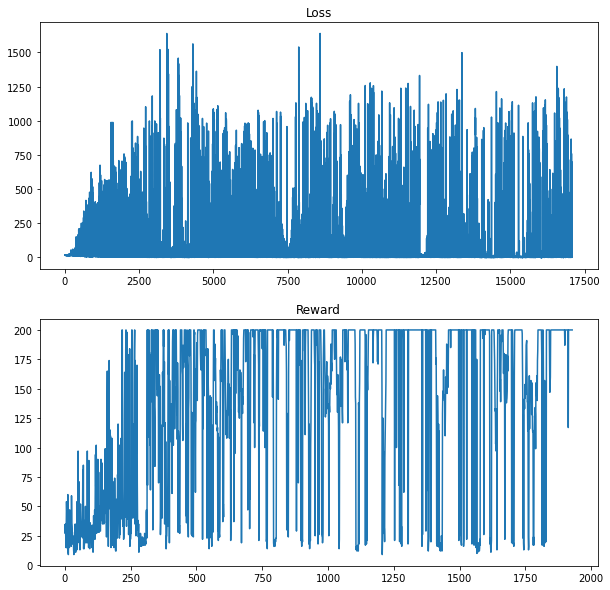

In [8]:
plt.figure(figsize=(10, 10))
charts=[losses,total_rewards]
titles=['Loss','Reward']
for i, (chart, title) in enumerate(zip(charts,titles)):
  ax=plt.subplot(2,1,i+1)
  plt.plot(chart)
  plt.title(title)